In [23]:
from IPython.display import display, Markdown
display(Markdown(open('README.md','r').read()))

# Modeling Paris traffic

After my previous two studies on [traveling times in Paris](https://github.com/astyonax/TimingParis) and [traffic in Paris](https://github.com/astyonax/heartbeat-traffic) it is time to model the traffic in Paris. As before, I use the dataset of OpenDataParis reporting the number of cars going through checkpoints fixed on the city, the data is sampled once per hour.

In this case, by modeling I mean finding a function `F(x(t))=x(t+1h)` to propagate forward of 1h any arbitrary state.
For the sake of learning some more tricks with `pytorch`, I'll first make an NN model based on a LSTM cell.

TL;DR: **NOT** a success story yet:
[notebook here](LSTM-2.ipynb) and [full code here](lstm.py).

To see: https://discuss.pytorch.org/t/lstm-time-series-prediction/4832

## The data

The data is a coarse grained version of the raw dataset.
It is a matrix ~ 300x2000  (time x features), visualized in [traffic in Paris](https://github.com/astyonax/heartbeat-traffic).

## The model
The model, which contains the NN itself, the optimizer, the data scaler (scikit.learn's RobustScaler) and the data loader is in the file `lstm.py`.

To the incoming data, 3 features are appended:
1. the time (hour)
2. cos(h/24)^2
3. sin(h/24)^2


### The NN

```
    Linear(in,hid)->
    Cell(hid,hid)->
    [Cell2(hid,hid)->] *optional layer
    Linear(hid,in)->
    Max(in)
```
The incoming data has `in` dimensions, which are squeezed to `hid` but the linear map,
then the `LSTM` cell operates, and the `hid` counters are decompressed to the original number.
The idea of compressing comes about because PCA showed that 1 mode covers about 90% of the signal, so may be there is no need have a 2000 dimensional LSTM cell.

### Optimization

When learning NN and deep-learning, we are usually confronted with the need to learn the model weights.
But, we need to `learn` or some-how find/optimize the hyperparamters too.

Finding the best hyper-parameters (HP) it's usually a pain. To avoid wasting time,
I turned to the idea that if a set of HP performs better than other on a small number of epochs, it will also perform better on a long optimization.

So a first genetic optimization algorithm (GEA), in `gea.py`, optimizes for the HP leading to the best validation (see later)  in 1000 epochs.
This set of HP are then used to train up to 1e5 epochs (it's really fast, just minutes).

The individuals of the GEA are a dictionary of HP: window size, hidden dimensions, and weight decay.
To evaluate their fitness I simply train the model with the given set of parameters (training is done with `Adagrad(lr=0.1)`.

**Learning** is measured with `MSELoss` or mean-squared-error between the predicted counts and the real ones,
**validation** is MSE between the average predicted and real counts at fixed time.

## Result
### Average cars/counter/hour
![](plots/average.png)
### Cars through a single counter
![](plots/single.png)

### On the ML
Well.. we get that the machine does not learn the peaks, and has a rather noisy signal (see below).
Plus, it essentially ignores the time signal. Probably there is a way to get it included.
May be a sort of convolutional approach would help bcs many counters are strogly correlated (as shown by the PCA).

### On the traffic
Since there is no conservation law for number of cars though all counters, we should not expect the machine to be able to propagate forward
an arbitrary state. This is obvious _a posteriori_ but I didn't though of it initially.

Even with a simple linear model $y_{t+1}=W_{t,t+1}y_t+b_t$ and enforcing that $|W|=1$, the bias has to be not zero $b_t\neq 0$ then the machine can just `learn` the number of expected cars at time $t+1$. Indeed, then it is more efficient to learn $y_{t+1}=0_{t,t+1}y_t+b_t$!

I see no way to estimate the flux.. may be only by keeping the average constant?


In [3]:
%pylab inline
import pandas as pd
from torch.autograd import Variable
from torch import nn
import torch
import glob
import lstm
from lstm import RNN

Populating the interactive namespace from numpy and matplotlib


**HP** window 2, hidden dim 28 , weight decay -8 are found with GEA

In [4]:
get_epoch = lambda x:int(x.split('/')[1].split('_')[0])
sorted_epochs = sorted(glob.glob('2_28_-8/*_*'),key=get_epoch)

epochs = []
error_history = []
valid_history = []
for j in sorted_epochs:
    th = open(j+'/train_history.txt','r').readlines()
    for line in th:
        if line:
            step,the,thv=line.split()
            epochs.append(get_epoch(j)+int(step))
            error_history.append(float(the))
            valid_history.append(float(thv))
    

Text(0.5,1,u'learning error')

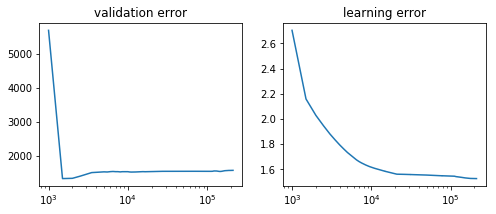

In [5]:
fig,(ax,bx) = plt.subplots(1,2,figsize=(8,3))

ax.semilogx(epochs,valid_history)
bx.semilogx(epochs,error_history)
ax.set_title('validation error')
bx.set_title('learning error')

**load** model after 202000 epochs

In [6]:
model = torch.load('2_28_-8/202000_epochs/model.pth')

/home/astyonax/.anaconda/envs/pytorch/lib/python2.7/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'lstm.RNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [7]:
Q = lstm.scaler.fit_transform(lstm.time_series)

## Plot Validation

In [17]:
W=1
real = []
pred = []
model.eval()
time = range(W,Q.shape[0]-1)
for i in time:
    t0 = Q[i-W:i]
    t1 = Q[i]
    t1_pred = model(lstm.np2y(t0)).squeeze().data.numpy()
        
#     print t1.mean(),t1_pred.mean()
    real.append(lstm.scaler.inverse_transform(t1.reshape(1,-1)).mean())
    pred.append(lstm.scaler.inverse_transform(t1_pred.reshape(1,-1)).mean())

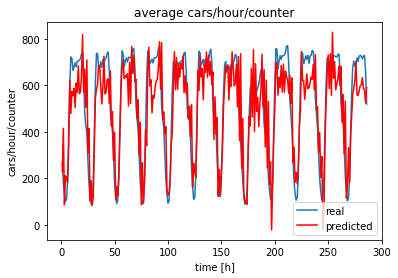

In [20]:
plt.plot(time,real,label='real')
plt.plot(time,pred,'r',label='predicted')
plt.xlabel('time [h]')
plt.ylabel('cars/hour/counter')
plt.title('average cars/hour/counter')
plt.savefig('plots/average.png',dpi=96,bbox_inches='tight')
plt.legend(loc='best')

### Plot prediction on single counter/feature

In [21]:
real = []
pred = []
model.eval()
w= 2
time = range(w,Q.shape[0]-1)
for i in time:
    t0 = Q[i-w:i]
    t1 = Q[i]
    t1_pred = model(lstm.np2y(t0)).squeeze().data.numpy()
        
#     print t1.mean(),t1_pred.mean()
    real.append(lstm.scaler.inverse_transform(t1.reshape(1,-1)).squeeze()[18])
    pred.append(lstm.scaler.inverse_transform(t1_pred.reshape(1,-1)).squeeze()[18])

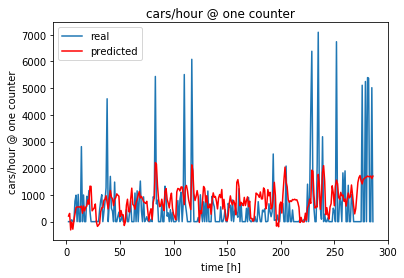

In [22]:
plt.plot(time,real,label='real')
plt.plot(time,pred,'r',label='predicted')
plt.xlabel('time [h]')
plt.ylabel('cars/hour @ one counter')
plt.title('cars/hour @ one counter')
plt.savefig('plots/single.png',dpi=96,bbox_inches='tight')
plt.legend(loc='best')

## Plot prediction

In [ ]:
print(Q.shape)
_t0 = Q.copy()
_t0=_t0[0]
_t0[3:]=np.random.rand(Q.shape[1]-3)*1e5

t0 = lstm.scaler.transform(_t0.reshape(1,-1))
t0.shape


In [ ]:
import copy
model_unbiased = copy.deepcopy(model)

In [ ]:
pred = [t0,]
model.eval()
time = range(1,Q.shape[0]-1)
for i in time:
    tprec=t0
    tprec=lstm.scaler.inverse_transform(tprec)
    tprec[:,0]=i%24
    tprec[:,1]=np.cos(i/24.)
    tprec[:,2]=np.sin(i/24.)
    tprec=lstm.scaler.transform(tprec)
    t1 = model(lstm.np2y(tprec)).squeeze().data.numpy()
    pred.append(t1.reshape(1,-1))

pred = np.asarray([lstm.scaler.inverse_transform(j).flatten() for j in pred])

In [ ]:
pred.shape

In [ ]:
plt.matshow(pred[1:])

### Conclusions - LSTM

So, the machine is learning, definitely, as shown in the previous plots. But
1. It still does not reproduce the high frequency peaks
2. It does not use the information about time, bcs the quantity is essentially discarded when it's the only paramter changing on the input state (prev plot).